In [1]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB


In [2]:
RANDOM_STATE = 42

In [3]:
data = pd.read_csv("dataset2/pricerunner_aggregate.csv")

# EDA

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35311 entries, 0 to 35310
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Product ID       35311 non-null  int64 
 1   Product Title    35311 non-null  object
 2    Merchant ID     35311 non-null  int64 
 3    Cluster ID      35311 non-null  int64 
 4    Cluster Label   35311 non-null  object
 5    Category ID     35311 non-null  int64 
 6    Category Label  35311 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.9+ MB


In [5]:
data.describe()

,Product ID,Merchant ID,Cluster ID,Category ID
count,35311.000000,35311.000000,35311.000000,35311.000000
mean,26150.800176,120.501883,30110.687633,2618.142930
std,13498.191220,117.045557,18410.265642,3.600708
min,1.000000,1.000000,1.000000,2612.000000
25%,14958.500000,17.000000,6123.000000,2615.000000
50%,27614.000000,75.000000,40630.000000,2619.000000
75%,37508.500000,253.000000,44059.000000,2622.000000
max,47358.000000,371.000000,47525.000000,2623.000000


In [6]:
data.sample(5)

,Product ID,Product Title,Merchant ID,Cluster ID,Cluster Label,Category ID,Category Label
18654,28783,gorenje gi66160s geschirrsp ler integrierbar,119,40956,Gorenje GI66160S Stainless Steel,2619,Dishwashers
32037,43747,neff ki1412s30g integrated tall fridge,7,46149,Neff KI1412S30G Integrated,2623,Fridges
18897,29037,zanussi zdv12002fa 9 place slimline fully inte...,293,41046,Zanussi ZDV12002FA Integrated,2619,Dishwashers
6149,12177,samsung ue28j4100ak. display diagonal 71.1 cm ...,18,4756,Samsung UE28J4100,2614,TVs
5636,11642,samsung uemu6400 inch ultra hd 4k smart tv,53,4603,Samsung UE55MU6400,2614,TVs


In [7]:
data.columns = [
    "product_id",
    "product_title",
    "merchant_id",
    "cluster_id",
    "cluster_label",
    "category_id",
    "category_label",
]

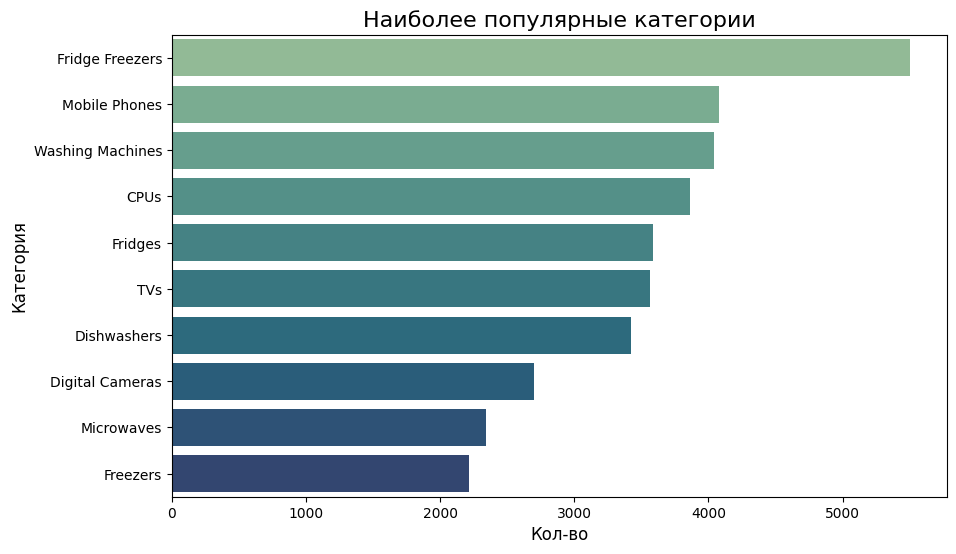

In [8]:
top_categories = data["category_label"].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_categories.values,
    y=top_categories.index,
    palette="crest",
    hue=top_categories.index,
)
plt.title("Наиболее популярные категории", fontsize=16)
plt.xlabel("Кол-во", fontsize=12)
plt.ylabel("Категория", fontsize=12)
plt.show()

/tmp/ipykernel_3032/3615502772.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


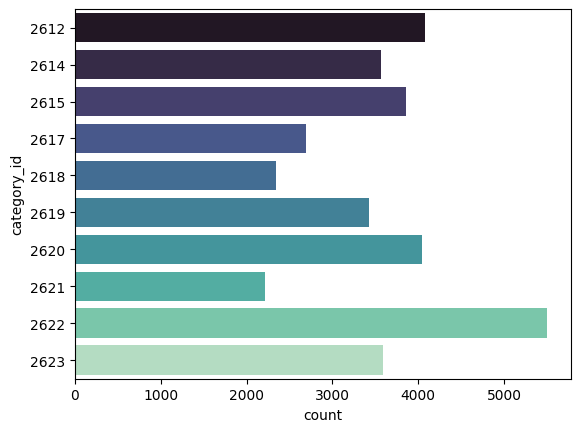

In [9]:
sns.barplot(
    x=data["category_id"].value_counts(),
    y=data["category_id"].value_counts().index,
    palette="mako",
    orient="h",
)
plt.show()

In [10]:
unique_labels_per_id = data.groupby("category_id")["category_label"].nunique()
non_unique_ids = unique_labels_per_id[unique_labels_per_id > 1]
non_unique_ids

Series([], Name: category_label, dtype: int64)

Все Id соответствуют category_label

In [11]:
category_mapping = (
    data[["category_id", "category_label"]]
    .drop_duplicates()
    .set_index("category_id")["category_label"]
    .to_dict()
)
print(f"Сопоставление лейблов и номеров категорий \n", category_mapping)

Сопоставление лейблов и номеров категорий 
 {2612: 'Mobile Phones', 2614: 'TVs', 2615: 'CPUs', 2617: 'Digital Cameras', 2618: 'Microwaves', 2619: 'Dishwashers', 2620: 'Washing Machines', 2621: 'Freezers', 2622: 'Fridge Freezers', 2623: 'Fridges'}


In [12]:
x = data["product_title"]
y = data["category_id"]

In [13]:
x_train, x_valid, y_train, y_valid = train_test_split(
    x, y, test_size=0.2, random_state=RANDOM_STATE
)

In [14]:
tfidf = TfidfVectorizer(
    max_features=10000, stop_words="english", ngram_range=(1, 4), lowercase=True
)
x_train = tfidf.fit_transform(x_train)
x_valid = tfidf.transform(x_valid)

In [15]:
with open("tfidf.pkl", "wb") as tfidf_file:
    pickle.dump(tfidf, tfidf_file)

## Model 1 - CatBoost

In [16]:
model = CatBoostClassifier(
    random_seed=RANDOM_STATE,
    iterations=1000,
    depth=5,
    learning_rate=0.15,
    eval_metric="TotalF1",
    use_best_model=True,
    task_type="GPU",
    devices="0:1",
)
model.fit(x_train, y_train, eval_set=(x_valid, y_valid), verbose=500, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5116548	test: 0.5028745	best: 0.5028745 (0)	total: 59.6ms	remaining: 59.6s
500:	learn: 0.9449430	test: 0.9332538	best: 0.9332538 (492)	total: 23.8s	remaining: 23.8s
999:	learn: 0.9502459	test: 0.9375182	best: 0.9375182 (997)	total: 46.6s	remaining: 0us
bestTest = 0.9375181512
bestIteration = 997
Shrink model to first 998 iterations.


In [17]:
print(classification_report(y_valid, model.predict(x_valid)))

              precision    recall  f1-score   support

        2612       0.88      1.00      0.93       818
        2614       0.97      0.97      0.97       723
        2615       1.00      0.99      0.99       771
        2617       1.00      0.97      0.98       542
        2618       0.97      0.93      0.95       469
        2619       0.88      0.94      0.91       662
        2620       0.94      0.93      0.94       796
        2621       0.98      0.90      0.94       439
        2622       0.94      0.89      0.92      1115
        2623       0.87      0.86      0.87       728

    accuracy                           0.94      7063
   macro avg       0.94      0.94      0.94      7063
weighted avg       0.94      0.94      0.94      7063



In [18]:
with open("model1.pkl", "wb") as model1_file:
    pickle.dump(model, model1_file)

## Model 2 - logistic regression

In [19]:
model2 = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
model2.fit(x_train, y_train)
print(classification_report(y_valid, model2.predict(x_valid)))

              precision    recall  f1-score   support

        2612       0.98      1.00      0.99       818
        2614       0.97      0.99      0.98       723
        2615       1.00      0.99      1.00       771
        2617       1.00      1.00      1.00       542
        2618       0.97      0.95      0.96       469
        2619       0.89      0.95      0.92       662
        2620       0.94      0.94      0.94       796
        2621       0.98      0.91      0.94       439
        2622       0.94      0.92      0.93      1115
        2623       0.90      0.90      0.90       728

    accuracy                           0.95      7063
   macro avg       0.96      0.95      0.95      7063
weighted avg       0.95      0.95      0.95      7063



In [20]:
with open("model2.pkl", "wb") as model2_file:
    pickle.dump(model2, model2_file)

## Model 3 - Naive Bayes

In [21]:
model3 = MultinomialNB()
model3.fit(x_train, y_train)
print(classification_report(y_valid, model3.predict(x_valid)))

              precision    recall  f1-score   support

        2612       0.99      0.99      0.99       818
        2614       0.97      0.99      0.98       723
        2615       1.00      0.99      1.00       771
        2617       0.99      1.00      0.99       542
        2618       1.00      0.94      0.97       469
        2619       0.88      0.94      0.91       662
        2620       0.95      0.94      0.94       796
        2621       0.98      0.77      0.87       439
        2622       0.85      0.92      0.88      1115
        2623       0.88      0.85      0.86       728

    accuracy                           0.94      7063
   macro avg       0.95      0.93      0.94      7063
weighted avg       0.94      0.94      0.94      7063



In [22]:
with open("model3.pkl", "wb") as model3_file:
    pickle.dump(model3, model3_file)